# kNN vs Linear Regression¶


## Example I

### Data Generation

Set the model parameters like dimension and standard error, and store the two centers (each is a two-dim vector) in m1 and m2.

In [90]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier as knn
from sklearn import linear_model as lm

np.random.seed(100)

p = 2
s = 1      # sd for generating x   
n = 100    # 2n obs (in total); n from each class       
m1 = [1,0]
m0 = [0,1]

Generate n samples from each normal component. First, we generate a (2n)-by-p matrix with entries being iid samples form a normal dist with mean 0 and variance s-square. Then we form a (2n)-by-p matrix with the first n rows being the two-dimensional vector m1 (the center of the first normal component) and the next n rows being m2. We use command rep to generate repeated rows and use command rbind to stack two matrices vertically together.

In [91]:
n = 100  # generate the train data; n for each class
traindata = np.random.normal(size = (2 * n, p)) * s \
            + np.concatenate([np.array([m1] * n), np.array([m0] * n)])
Ytrain = np.concatenate(([1]*n, [0]*n))

Generate 2N test samples similarly.

In [92]:
N = 5000
testdata = np.random.normal(size = (2 * N, p)) * s \
           + np.concatenate([np.array([m1] * N), np.array([m0] * N)])
Ytest = np.concatenate(([1]*N, [0]*N))

### Visulization

Let’s take a look of the data. In the plot generated by the code below, points from two groups are colored in red and blue, respectively; the two centers are plotted as +, and a legend is added to explain the association of each color.

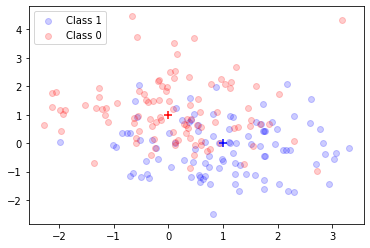

In [93]:
plt.scatter(traindata[:n, 0], traindata[:n, 1], c = "blue", alpha=0.2, label='Class 1')
plt.scatter(traindata[n:, 0], traindata[n:, 1], c = "red", alpha=0.2, label='Class 0')

plt.scatter(m1[0], m1[1], marker = '+', s = 80, c = "blue")
plt.scatter(m0[0], m0[1], marker = '+', s = 80, c = "red")

plt.legend()
plt.show()

In [40]:
m1

[1, 0]